In [39]:
# testing hysteresis parameter calculation? 
import numpy as np
import scipy.integrate as spi
from scipy.optimize import curve_fit
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib.collections as mcoll
import matplotlib.path as mpath

storm_directory = 'C:/Users/nicol/Documents/GitHub/La_Jara/Hysteresis/All_Summer_Storms'
storms = {}
for filename in os.listdir(storm_directory):
    # check if the file is a CSV file
    if filename.endswith('.csv'):
        file_path = os.path.join(storm_directory, filename) # construct the full file path
        df = pd.read_csv(file_path)                         # read the CSV file into a data frame
        df = df.dropna(subset=['Date_Time'])                # drop rows where 'Date/Time' is NaN  
        df['Date_Time'] = pd.to_datetime(df['Date_Time'])   # convert to datetime format
        df = df.set_index('Date_Time')                      # set date time as the index 
        df = df.dropna(how='all', axis=1)                   # drop columns where all values are NaN
        key = filename[:-4]                                 # remove the '.csv' from the filename to use as the dictionary key
        storms[key] = df                                    # store the data frame in the dictionary

## STORM 1 AS EXAMPLE ## 
SSC = storms['st3_down']['SS (uL/L)']
depth = storms['st3_down']['depth']
time = storms['st3_down'].index

In [45]:
storms['st3_down']

,SS (uL/L),SRP (mg/L),TP (mg/L),DOC (mg/L),POC (mg/L),N (mg/L),PP (mg/L),LAB ID,fDOM,Turbidity,P2C,P3C,P2C_depth,P3C_depth,depth
Date_Time,,,,,,,,,,,,,,,
2022-08-08 13:43:00,0.00,NaN,NaN,3.359,1.524,0.000,NaN,102,35.575,4.459,2723.150509,2724.205966,14.150947,21.796620,21.796620
2022-08-08 13:58:00,0.00,0.011474,0.029039,3.424,1.708,0.000,0.10,103,38.521,5.719,2723.156027,2724.215332,14.702693,22.733220,22.733220
2022-08-08 14:28:00,204.03,0.026917,0.063819,5.279,5.365,0.136,0.11,105,49.596,14.478,2723.169251,2724.233648,16.025080,24.564807,24.564807
2022-08-08 14:43:00,105.77,NaN,NaN,7.207,5.122,0.203,NaN,106,60.924,22.442,2723.167491,2724.240447,15.849132,25.244660,25.244660
2022-08-08 15:23:00,68.83,NaN,NaN,8.410,2.267,0.298,NaN,107,68.422,13.926,2723.160880,2724.244490,15.187998,25.649020,25.649020
2022-08-08 16:13:00,36.65,0.038928,0.040752,8.605,1.972,0.561,0.29,108,72.398,9.508,2723.156735,2724.239949,14.773533,25.194887,25.194887
2022-08-08 16:28:00,25.92,NaN,NaN,8.421,1.872,0.736,NaN,109,73.292,8.677,2723.155298,2724.238045,14.629820,25.004520,25.004520
2022-08-08 16:58:00,19.05,NaN,NaN,8.183,1.519,0.755,NaN,111,73.981,7.599,2723.155453,2724.233531,14.645287,24.553087,24.553087
2022-08-08 17:28:00,18.36,NaN,NaN,8.042,1.611,0.769,NaN,112,74.143,6.719,2723.154822,2724.231307,14.582167,24.330667,24.330667


In [44]:
# get rid of rows with NaN values in the SSC column
storms['st3_down'] = storms['st3_down'].dropna(subset=['SS (uL/L)'])

In [46]:
# determine rising and falling limbs
peak_idx = np.argmax(depth)  # index of max discharge
# include the peak discharge in both rising and falling limbs
rising_mask = np.arange(len(depth)) <= peak_idx  # rising limb includes everything up to and including the peak
falling_mask = np.arange(len(depth)) >= peak_idx  # falling limb includes everything starting from the peak

depth_rising, SSC_rising, time_rising = depth[rising_mask], SSC[rising_mask], time[rising_mask]
depth_falling, SSC_falling, time_falling = depth[falling_mask], SSC[falling_mask], time[falling_mask]

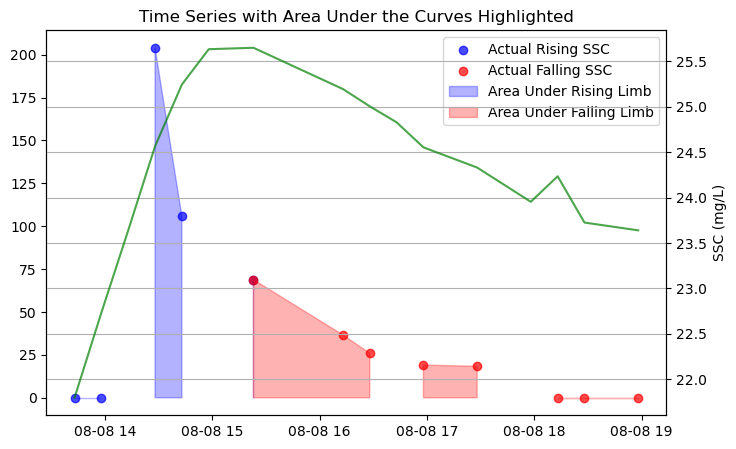

In [47]:
plt.figure(figsize=(8, 5))

# Plot actual SSC for rising and falling limbs
plt.scatter(time_rising, SSC_rising, color='blue', label='Actual Rising SSC', alpha=0.7)
plt.scatter(time_falling, SSC_falling, color='red', label='Actual Falling SSC', alpha=0.7)

# Highlight the areas under the curve using fill_between
plt.fill_between(time_rising, SSC_rising, color='blue', alpha=0.3, label='Area Under Rising Limb')
plt.fill_between(time_falling, SSC_falling, color='red', alpha=0.3, label='Area Under Falling Limb')

# Plot water depth in another axis
plt.legend()
ax2 = plt.gca().twinx()
plt.plot(time, depth, color='green', label='Water Depth', alpha=0.7)

# Labels and legend
plt.xlabel("Time")
plt.ylabel("SSC (mg/L)")
plt.title("Time Series with Area Under the Curves Highlighted")
#plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [49]:
# calculate the areas (assuming time is as sequential indices)
area_rising = np.trapz((SSC_rising), time_rising)
area_falling = np.trapz((SSC_falling), time_falling)

# Cclculate hysteresis index
HI = area_rising / area_falling

print(f"Area under rising limb: {area_rising}")
print(f"Area under falling limb: {area_falling}")
print(f"Hysteresis Index (HI): {HI:.4f}")

Area under rising limb: NaT
Area under falling limb: NaT
Hysteresis Index (HI): nan


c:\Users\nicol\miniconda3\envs\geopandas2\lib\site-packages\numpy\lib\function_base.py:4832: RuntimeWarning: invalid value encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
